In [49]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import colour
import scipy.interpolate
import torch
import torchvision.io
import torchmetrics.functional.image
import pathlib
import tqdm
import sklearn.linear_model
from utils import hsi_observer
from model import MST_Plus_Plus

# Спектральные изображения
## Напоминание об обычных изображениях

<img src="fig/image-formation.png" style="max-width: 50%;">

Формирование изображения в камере:

1. Фотоматрица преобразует свет в электрический сигнал.
2. Сигнал обрабатывается и преобразуется в JPG.

На первом этапе участвуют две сущности:
* Свет: описывается спектром $F(\lambda)$.
* Фотоматрица: описывается спектральной чувствительностью $\vec\chi(\lambda) = [\chi_R(\lambda), \chi_G(\lambda), \chi_B(\lambda)]^T$.

Выражение для итогового цветового отклика:
$$
\vec{с} = \int_a^b F(\lambda) \vec\chi(\lambda) d\lambda,
$$
где $[a, b]$ &mdash; спектральный диапазон фотоматрицы (вне него $\vec\chi(\lambda) = 0$).

Изображение &mdash; набор векторов типа $\vec{c}$, выровненных по сетке размера $``\text{высота} \times \text{ширина}"$, то есть массив $H \times W \times 3$.

Спектральное изображение могло бы быть таким же набором функций $F(\lambda)$.

Конечно, хранить всю функцию $F(\lambda)$ невозможно, да и нет смысла, поэтому обычно используется её дискретизированное представление (замер на некоторых длинах волн): $\vec{f} := [F(\lambda_1), F(\lambda_2), \ldots, F(\lambda_n)]^T$. Соответственно, вектор-функция спектральных чувствительностей $\vec\chi(\lambda)$ превращается в матрицу $\Chi := [\vec\chi(\lambda_1) | \vec\chi(\lambda_2) | \ldots | \vec\chi(\lambda_n)]$. Новое выражение для цветового отклика:
$$
\vec{c} = \Chi \vec{f}.
$$

А _спектральное изображение_ &mdash; набор таких векторов $\vec{f}$ (массив $H \times W \times n$).


## Пример спектрального изображения
Собираются при помощи спектральных камер.

Взглянем на пример.

In [66]:
path = '/home/cromtus/hyperspectral/datasets/NTIRE2022/ARAD_1K_0865.mat'
with h5py.File(path, 'r') as f:
    bands = np.squeeze(f['bands'][:])
    hsi = f['cube'][:].transpose(2, 1, 0)

print('Bands:', bands)
print('HSI shape:', hsi.shape)


Bands: [ 400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
  520.  530.  540.  550.  560.  570.  580.  590.  600.  610.  620.  630.
  640.  650.  660.  670.  680.  690.  700.]
HSI shape: (482, 512, 31)


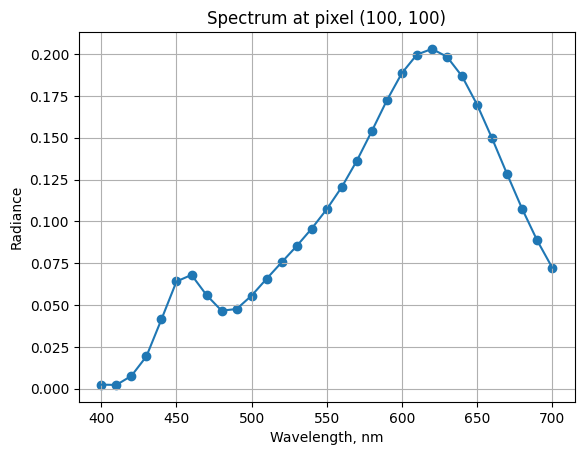

In [67]:
x, y = 100, 100
plt.plot(bands, hsi[y, x, :])
plt.scatter(bands, hsi[y, x, :])
plt.title(f'Spectrum at pixel ({x}, {y})')
plt.xlabel('Wavelength, nm')
plt.ylabel('Radiance')
plt.grid()
plt.show()


Как посмотреть на содержание спектрального изображения?

Можно по спектру получить цвет в координатах XYZ, а из них &mdash; RGB.

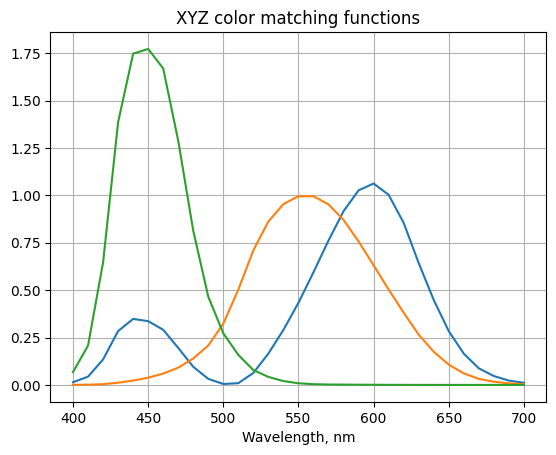

In [28]:
cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
cmfs = scipy.interpolate.interp1d(cmfs.wavelengths, cmfs.values, axis=0)(bands)
plt.plot(bands, cmfs)
plt.title('XYZ color matching functions')
plt.xlabel('Wavelength, nm')
plt.grid()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.466343345033..2.67321655439].


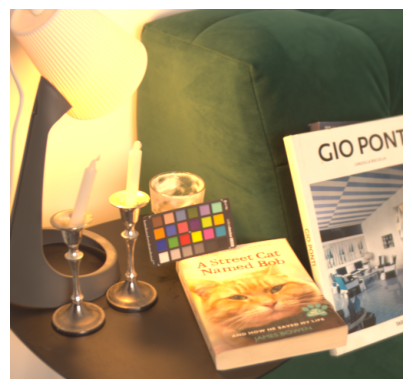

In [29]:
img_xyz = hsi @ cmfs
img_rgb = colour.XYZ_to_sRGB(img_xyz)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [68]:
await hsi_observer(hsi, bands, host='radu', slice_width=10, slice_height=10, slice_step=1)

## Датасеты спектральных изображений

Сводная таблица:

| Имя | # изображений | Тип спектральных данных | Длины волн (нм) |
| --- | --- | --- | --- |
| CAVE | 32 | Отражательная способность | 400&ndash;700 |
| Harvard | 79 | Спектр-стимул | 420&ndash;720 |
| NTIRE2022 (ARAD-1K) | 950 | Спектр-стимул | 400&ndash;700 |
| KAUST | 409 | Отражательная способность | 400&ndash;730 |
| ICVL | 200 | Спектр-стимул | 400&ndash;1000 |

Под "отражательной способностью" понимается результат деления каждого спектра-стимула сцены на спектр-стимул образца белого, присутствующего в сцене.

Основание: упрощённая модель формирования спектра-стимулы из отражательной способности и спектра источника света:

$$
F(\lambda) = \Phi(\lambda) I(\lambda),
$$

Примеры:

| NTIRE2022 | CAVE | KAUST |
| --- | --- | --- |
| ![](rendered.lnk/NTIRE2022/ARAD_1K_0086.jpg) | ![](rendered.lnk/CAVE/fake_and_real_peppers_ms.jpg) | ![](rendered.lnk/KAUST/2019-08-26_040.jpg) |


## Применение спектральных изображений
### Дистанционное зондирование
Ситуации, когда требуется сделать выводы о составе вещества, которое находится на большом расстоянии от наблюдателя и поэтому не может быть изучено контактно.

* Агрономия
* Геология
* Медицина
* Археология
* ...

### Колориметрия
Спектральные изображения хороши тем, позволяют моделировать любую камеру, если её спектральные чувствительности известны.

# Спектральная реконструкция
Это задача восстановления спектрального изображения по его цветному аналогу.

Но как? Как можно восстановить, скажем, 31-мерный вектор по его 3-мерному образу?

Ответ: в общем случае никак, но если у нас есть некоторые априорные ограничения на спектр, то можно с некоторой точностью.

Интуитивная иллюстрация априорных знаний о многомерном объеме данных:

![](fig/low-dimensional.png)


## Спектральная реконструкция линейной регрессией


In [45]:
train_files = sorted(pathlib.Path('NTIRE2022.lnk').glob('*.mat'))[:900]
spectra = []
for file in tqdm.tqdm(train_files):
    with h5py.File(file, 'r') as f:
        step = 14
        partial_hsi = f['cube'][:, ::step, ::step][:]
        hsi_spectra = partial_hsi.reshape(31, -1).T
        spectra.append(hsi_spectra)
spectra = np.concatenate(spectra)


  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [01:27<00:00, 10.25it/s]


In [70]:
spectra.shape

(1165500, 31)

In [50]:
with h5py.File('NTIRE2022.lnk/ARAD_1K_0921.mat', 'r') as f:
    gt = f['cube'][:].transpose(2, 1, 0)

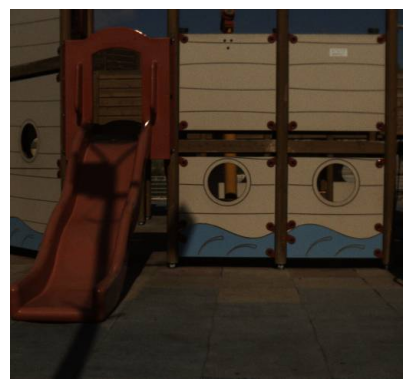

In [63]:
plt.imshow(plt.imread('rendered.lnk/NTIRE2022_JPG/Valid_RGB/ARAD_1K_0921.jpg'))
plt.axis('off')
plt.show()

In [59]:
def results(pred, gt_torch):
    pred_subimg = pred[:, :, ::step, ::step]
    gt_subimg = gt_torch[:, :, ::step, ::step]
    pred_spectra = pred_subimg.reshape(31, -1).T.numpy()
    gt_spectra = gt_subimg.reshape(31, -1).T.numpy()
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].plot(bands, pred_spectra.T, c='k', alpha=0.01)
    ax[0].set_title('Predicted')
    ax[0].set_xlabel('Wavelength, nm')
    ax[0].set_ylabel('Radiance')
    ax[0].grid()
    ax[1].plot(bands, gt_spectra.T, c='k', alpha=0.01)
    ax[1].set_title('Ground truth')
    ax[1].set_xlabel('Wavelength, nm')
    ax[1].set_ylabel('Radiance')
    ax[1].grid()
    plt.show()
    spectral_angle_mapper = torchmetrics.functional.image.spectral_angle_mapper(pred, gt_torch).item()
    spectral_angle_mapper *= 180 / torch.pi
    print(f'Spectral angle: {spectral_angle_mapper:.2f} degrees')


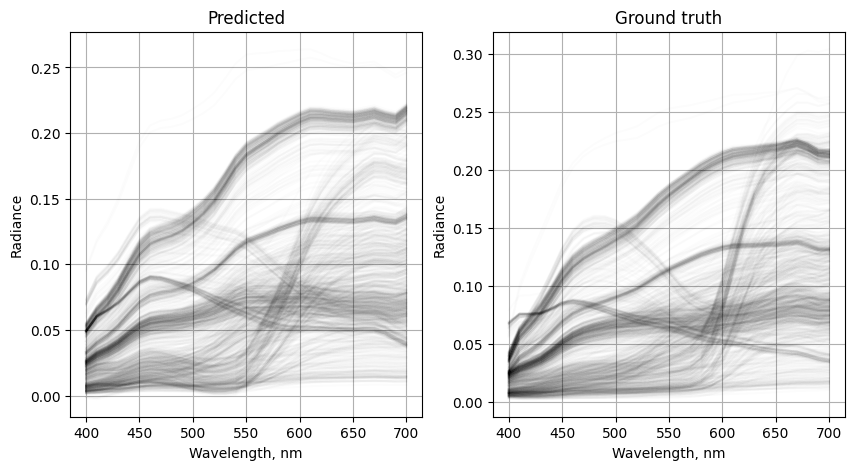

Spectral angle: 4.50 degrees


In [60]:
xyz = spectra @ cmfs
lr = sklearn.linear_model.LinearRegression(fit_intercept=False)
lr.fit(xyz, spectra)

image_xyz = gt @ cmfs
pred = image_xyz @ lr.coef_.T

pred = torch.from_numpy(pred)
pred = pred.to(torch.float32)
pred = pred.permute(2, 0, 1)
pred = pred.unsqueeze(0)

gt_torch = torch.from_numpy(gt)
gt_torch = gt_torch.permute(2, 0, 1)
gt_torch = gt_torch.to(torch.float32)
gt_torch = gt_torch.unsqueeze(0)

results(pred, gt_torch)


## Спектральная реконструкция нейронной сетью из JPG
Cai, Yuanhao, et al. "MST++: Multi-stage spectral-wise transformer for efficient spectral reconstruction." _Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition_. 2022.

<img src="https://raw.githubusercontent.com/caiyuanhao1998/MST-plus-plus/master/figure/MST.png" width="100%">

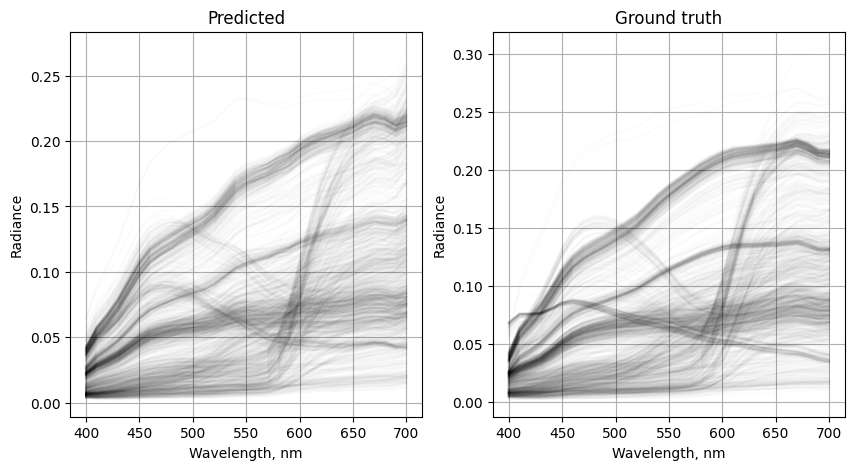

Spectral angle: 3.31 degrees


In [65]:
model = MST_Plus_Plus()
model.load_state_dict(torch.load('weights.pth', weights_only=True)['state_dict'])
model.eval()

img = torchvision.io.read_image('rendered.lnk/NTIRE2022_JPG/Valid_RGB/ARAD_1K_0921.jpg')
img = img.to(torch.float32) / 255
img = img.unsqueeze(0)

with torch.no_grad():
    pred = model(img)

results(pred, gt_torch)
